## Exercise 07 — Heatmap

Heatmap visualizations of checker commits split by weekday and hour for user accounts only.

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [ ]:
plt.style.use('seaborn-v0_8-white')
DB_PATH = '../data/checking-logs.sqlite'
WEEKDAY_ORDER = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
WEEKDAY_MAP = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
HOUR_RANGE = list(range(24))

In [11]:
with sqlite3.connect(DB_PATH) as connection:
    checker_info = pd.read_sql_query("PRAGMA table_info('checker');", connection)
checker_info

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,status,TEXT,0,None,0
2,2,success,INTEGER,0,None,0
3,3,timestamp,TIMESTAMP,0,None,0
4,4,numTrials,INTEGER,0,None,0
5,5,labname,TEXT,0,None,0
6,6,uid,TEXT,0,None,0


In [12]:
with sqlite3.connect(DB_PATH) as connection:
    checker_sample = pd.read_sql_query(
        """
        SELECT uid, timestamp, labname
        FROM checker
        WHERE uid LIKE 'user_%'
        ORDER BY timestamp
        LIMIT 5
        """,
        connection,
        parse_dates=['timestamp']
    )
checker_sample

,uid,timestamp,labname
0,user_4,2020-04-17 05:19:02.744528,project1
1,user_4,2020-04-17 05:22:35.249331,project1
2,user_4,2020-04-17 05:22:45.549397,project1
3,user_4,2020-04-17 05:34:14.691200,project1
4,user_4,2020-04-17 05:34:24.422370,project1


In [13]:
weekday_query = """
SELECT
    uid,
    CAST(STRFTIME('%w', timestamp) AS INTEGER) AS weekday_num,
    COUNT(*) AS commits
FROM checker
WHERE uid LIKE 'user_%'
GROUP BY uid, weekday_num
"""

hour_query = """
SELECT
    uid,
    CAST(STRFTIME('%H', timestamp) AS INTEGER) AS hour,
    COUNT(*) AS commits
FROM checker
WHERE uid LIKE 'user_%'
GROUP BY uid, hour
"""

with sqlite3.connect(DB_PATH) as connection:
    weekday_counts = pd.read_sql_query(weekday_query, connection)
    hour_counts = pd.read_sql_query(hour_query, connection)

weekday_counts.head(), hour_counts.head()

(      uid  weekday_num  commits
 0  user_0            1        3
 1  user_1            0       43
 2  user_1            3        1
 3  user_1            4       39
 4  user_1            6        1,
       uid  hour  commits
 0  user_0    17        3
 1  user_1    12        1
 2  user_1    16        1
 3  user_1    17        8
 4  user_1    19       21)

In [14]:
weekday_counts['weekday_name'] = weekday_counts['weekday_num'].map(WEEKDAY_MAP)
weekday_counts = weekday_counts[['uid', 'weekday_name', 'commits']]
weekday_totals = weekday_counts.groupby('uid')['commits'].sum().sort_values(ascending=False)
weekday_heatmap = (
    weekday_counts.pivot(index='weekday_name', columns='uid', values='commits')
    .reindex(WEEKDAY_ORDER)
    .fillna(0)
)
weekday_heatmap = weekday_heatmap.loc[:, weekday_totals.index]

hour_heatmap = (
    hour_counts.pivot(index='hour', columns='uid', values='commits')
    .reindex(HOUR_RANGE)
    .fillna(0)
)
hour_heatmap = hour_heatmap.loc[:, weekday_totals.index]

weekday_totals_df = weekday_totals.reset_index(name='total_commits')
hour_totals_df = hour_counts.groupby('uid')['commits'].sum().reindex(weekday_totals.index).reset_index(name='total_commits')

weekday_heatmap.head()

uid,user_4,user_14,user_2,user_25,user_19,user_26,user_20,user_31,user_10,user_3,...,user_17,user_16,user_27,user_15,user_6,user_11,user_7,user_22,user_23,user_0
weekday_name,,,,,,,,,,,,,,,,,,,,,
Mon,35.0,50.0,24.0,14.0,7.0,0.0,23.0,5.0,0.0,46.0,...,8.0,10.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0
Tue,86.0,87.0,131.0,44.0,9.0,1.0,0.0,0.0,16.0,11.0,...,4.0,5.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0
Wed,33.0,0.0,32.0,15.0,0.0,34.0,8.0,0.0,37.0,0.0,...,1.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0
Thu,108.0,17.0,4.0,40.0,78.0,51.0,96.0,7.0,77.0,7.0,...,17.0,14.0,15.0,5.0,2.0,0.0,0.0,2.0,6.0,0.0
Fri,61.0,0.0,0.0,10.0,10.0,2.0,7.0,35.0,1.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
weekday_totals_df.head(), hour_totals_df.head()

(       uid  total_commits
 0   user_4            368
 1  user_14            259
 2   user_2            235
 3  user_25            233
 4  user_19            176,
        uid  total_commits
 0   user_4            368
 1  user_14            259
 2   user_2            235
 3  user_25            233
 4  user_19            176)

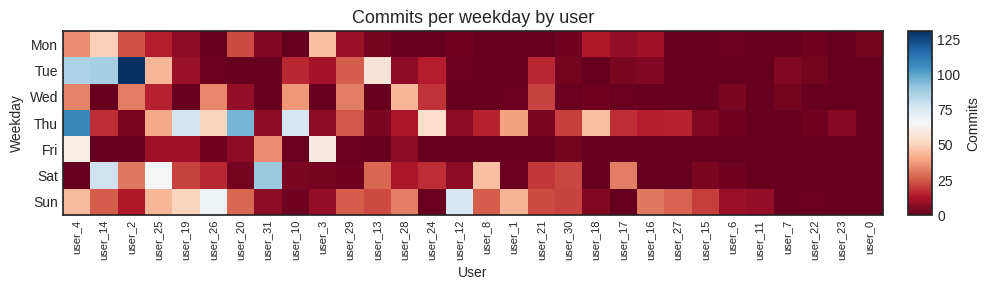

In [21]:
fig, ax = plt.subplots(figsize=(10, 3))
weekday_vmax = weekday_heatmap.values.max()
im = ax.imshow(
    weekday_heatmap.values,
    aspect='auto',
    cmap='RdBu',
    vmin=0,
    vmax=weekday_vmax
)
ax.set_xticks(range(len(weekday_heatmap.columns)))
ax.set_xticklabels(weekday_heatmap.columns, rotation=90, fontsize=8)
ax.set_yticks(range(len(WEEKDAY_ORDER)))
ax.set_yticklabels(WEEKDAY_ORDER)
ax.set_title('Commits per weekday by user', fontsize=13)
ax.set_xlabel('User')
ax.set_ylabel('Weekday')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.25)
cb = fig.colorbar(im, cax=cax)
cb.set_label('Commits')
plt.tight_layout()
plt.show()

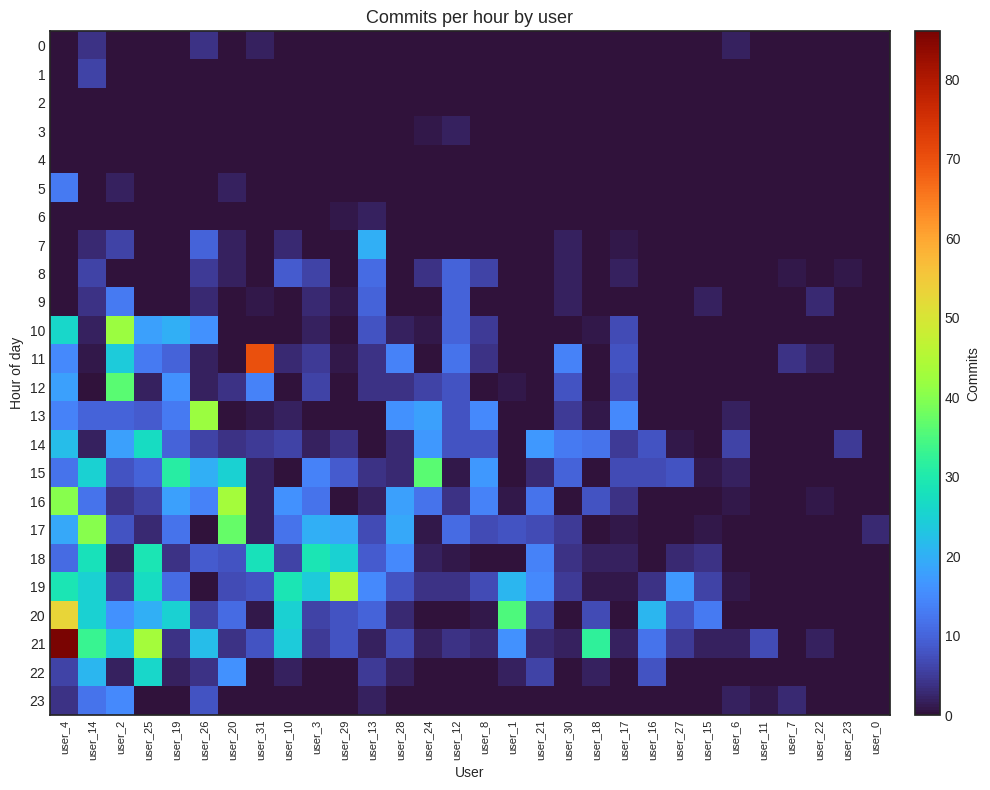

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
hour_vmax = hour_heatmap.values.max()
im = ax.imshow(
    hour_heatmap.values,
    aspect='auto',
    cmap='turbo',
    vmin=0,
    vmax=hour_vmax
)
ax.set_xticks(range(len(hour_heatmap.columns)))
ax.set_xticklabels(hour_heatmap.columns, rotation=90, fontsize=8)
ax.set_yticks(range(len(HOUR_RANGE)))
ax.set_yticklabels(HOUR_RANGE)
ax.set_title('Commits per hour by user', fontsize=13)
ax.set_xlabel('User')
ax.set_ylabel('Hour of day')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.25)
cb = fig.colorbar(im, cax=cax)
cb.set_label('Commits')
plt.tight_layout()
plt.show()

In [18]:
weekday_totals_by_day = weekday_counts.groupby('weekday_name')['commits'].sum().reindex(WEEKDAY_ORDER)

tuesday_top = weekday_counts[weekday_counts['weekday_name'] == 'Tue'].sort_values('commits', ascending=False).iloc[0]
thursday_top = weekday_counts[weekday_counts['weekday_name'] == 'Thu'].sort_values('commits', ascending=False).iloc[0]
least_busy_weekday = weekday_totals_by_day.idxmin()
least_busy_total = int(weekday_totals_by_day.min())

peak_hour_row = hour_counts.sort_values('commits', ascending=False).iloc[0]
peak_user = peak_hour_row['uid']
peak_hour = int(peak_hour_row['hour'])
peak_hour_commits = int(peak_hour_row['commits'])

print(f"Most Tuesday commits: {tuesday_top['uid']} ({int(tuesday_top['commits'])})")
print(f"Most Thursday commits: {thursday_top['uid']} ({int(thursday_top['commits'])})")
print(f"Least busy weekday overall: {least_busy_weekday} ({least_busy_total})")
print(f"Peak commits by hour: {peak_user} at {peak_hour}:00 ({peak_hour_commits})")

Most Tuesday commits: user_2 (131)
Most Thursday commits: user_4 (108)
Least busy weekday overall: Fri (196)
Peak commits by hour: user_4 at 21:00 (86)


1. **Which user has the most commits on Tuesday?** Answer: _user_2_.
2. **Which user has the most commits on Thursday?** Answer: _user_4_.
3. **On which weekday do users not like to make a lot of commits?** Answer: _Friday_.
4. **Which user made the largest number of commits at which hour?** Answer: _user_4, hour 21:00.